# Model Clustering

In [1]:
import pandas as pd
import numpy as np
import numpy.linalg as la
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv("data1.csv")
df=df.drop(['Unnamed: 0'],axis=1)
df

,0,1
0,1.004939,2.319887
1,3.412653,-1.637157
2,7.483318,-1.399250
3,0.702826,2.038150
4,0.287620,2.191703
...,...,...
1595,1.475069,2.329653
1596,4.277030,2.183024
1597,0.814996,2.246927
1598,7.999698,-1.811024


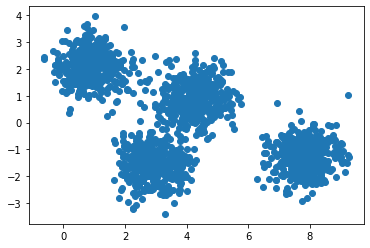

In [3]:
plt.scatter(df.iloc[:,0],df.iloc[:,1])
plt.show()

# Taking  Clusters as 4

The EM algorithm has two main steps: 
E step & M step

In the E-step, it assumes the values of the model
(that is wi, µi and Σi) and find P(C = i/xj), i = 1, 2, . . . k

In the M-step, it updates the parameters of the model. The
process iterates until convergence.

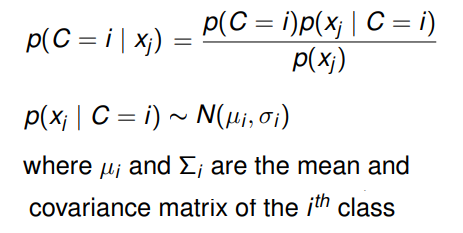

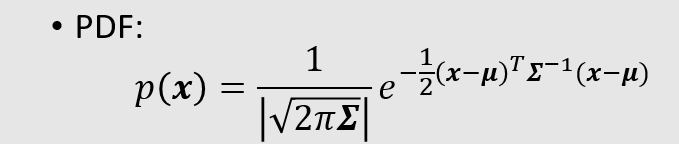

In [4]:
def Estep(x,mean,cov,Cluster_prob):
    N=len(x)
    k=len(mean)
    
    c_dp_prob= np.zeros((N, k))
    for n in range(N):
        u = np.array(mean)
        for i in range(k):            
            c_dp_prob[:,i]= Cluster_prob[i] * multivariate_normal.pdf(x,u[i],cov[i])
    
    c_dp_prob /= c_dp_prob.sum(axis=1, keepdims=True)
    return(c_dp_prob)

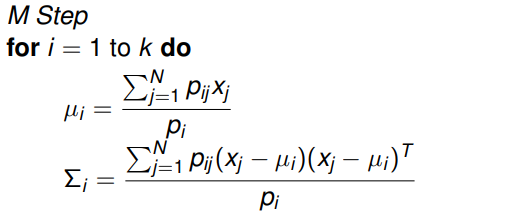

In [10]:
def Mstep(x,cov,c_dp_prob,point_prob):
    mean= np.matmul(c_dp_prob.T, x)
    
    for i in range(len(point_prob)):
        mean[i]=mean[i]/point_prob[i]
    
    for i in range(len(mean)):
        j = np.expand_dims(x, axis=1) - mean[i]
        s = np.matmul(j.transpose([0, 2, 1]), j)
        cov[i] = np.matmul(s.transpose(1, 2, 0), c_dp_prob[:, i] )
        cov[i] /= point_prob[i]
    return mean,cov

In [11]:
def train(df,iteration,eps):
    #initialization of parameters 
    k=4
    mean = df.sample(k)
    mean = np.array(mean)
    x    = np.array(df)
    r,c  = x.shape
    cov  = np.zeros(shape=(k,c,c))
    for i in range(k):
        cov[i] = np.eye(c)
    Cluster_prob = np.ones(k)* (1/k)  # prob of point belongs to cluster ,initially equally likely
    for n in range(iteration):
        c_dp_prob    = Estep(x,mean,cov,Cluster_prob)
        point_prob   = c_dp_prob.sum(axis=0) #point_prob is sum of probabilities of point belongs to cluster i
        Cluster_prob = point_prob/r
        u,cov        = Mstep(x,cov,c_dp_prob,point_prob) #getting updated values       
        
        #if cluster mean does not change we stop
        if np.sum(np.square(mean-u))<=eps:
            mean=u
            print("Training Completed in ",n,"Steps")
            break 
        mean=u
        
    return mean,cov,Cluster_prob,c_dp_prob
    

In [12]:
def predict(df,mean,cov,Cluster_prob,c_dp_prob,k):
    #computes for each point a probability of being generated by each component of the model. for trained mean    
    x=np.array(df)
    for i in range(k):
        c_dp_prob[:, i] = Cluster_prob[i] * multivariate_normal.pdf(x,mean[i],cov[i])
        labels = np.argmax(c_dp_prob,axis=1)        
        return labels

# Train

In [13]:
mean1,cov1,Cluster_prob,c_dp_prob=train(df,500,1e-6)
print(mean1)

Training Completed in  8 Steps
[[ 2.91998995 -1.57899042]
 [ 4.26305122  0.90392682]
 [ 7.8082182  -1.29806051]
 [ 0.92326234  2.07800228]]


# Test

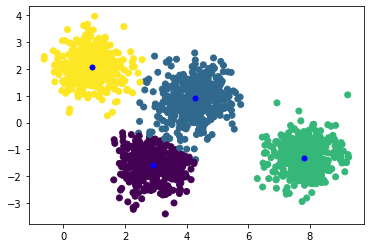

In [15]:
plt.scatter(df['0'],df['1'],c=predict(df,mean1,cov1,Cluster_prob,c_dp_prob,4))
plt.scatter(mean1[:,0],mean1[:,1],marker='.',s=100,c='b')

In [16]:
for i in range(4):
    print("Cluster :",i)
    print("Mean",mean1[i])    
    print('=============================')

Cluster : 0
Mean [ 2.91998995 -1.57899042]
Cluster : 1
Mean [4.26305122 0.90392682]
Cluster : 2
Mean [ 7.8082182  -1.29806051]
Cluster : 3
Mean [0.92326234 2.07800228]
